# import

In [1]:
%matplotlib inline
# from __future__ import unicode_literals, print_function, division
import random
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch import optim
from gensim.models import word2vec
from gensim.models import KeyedVectors
import numpy as np
import tqdm
import time
import math
from ML_utils import ML_utils

# set dataset

In [2]:
def del_space(list_in):
    index = []
    for num in range(len(list_in)):        
        remove_num = 0
        if list_in[num] == "" or list_in[num] == "\u3000":
            index.append(num)
    for num in range(len(index)):
        remove_index = index[num]-remove_num
        list_in.pop(remove_index)
        remove_num = remove_num+1
    return list_in

def file_to_word_list(data_path,clip_len):
    pairs = []
    with open(data_path,"r",encoding="utf-8") as f:
        i = 0
        for line in f:
            pair = line.split("\t")
            X = pair[0].strip(" ").split(" ")
            X = del_space(X)
            Y = pair[1].strip("\n").strip(" ").split(" ")
            Y = del_space(Y)
            if (len(X) <= clip_len) and (len(Y) <= clip_len):
                pairs.append([X,Y])            
    return pairs

def prepareData_vec(word_vectors,pairs,pairs_len):
    num = np.random.randint(0,pairs_len,1,np.int32)[0]
    pair = pairs[num]
    x = []
    y = []
    for word in pair[0]:
        x.append(word_vectors.get_vector(word))
    for word in pair[1]:
        y.append(word_vectors.get_vector(word))
    return x,y

def strlist_to_vec(word_vectors,strlist):    
    x = []
    for word in strlist:
        x.append(word_vectors.get_vector(word))
    return x

def wordvec2str(word_vectors,vec):
    return word_vectors.similar_by_vector(vec,1)

def showPlot(points):
    fig = plt.figure()
    subfig = plt.subplot(111)
    subfig.plot(points)
    plt.show()

def showPlot_avg(plot_losses,accumulation_num):
    new_list = []
    value = 0
    for i,v in enumerate(plot_losses):
        value = value+plot_losses[i]
        if ((i+1)%accumulation_num) == 0:
            new_list.append(value)
            value = 0 
    plt.plot(new_list)
    
#除以60秒向下取整換算成分鐘
def asMinutes(s):
    m = math.floor(s / 60)
    #除後剩下的秒數
    s -= m * 60
    #傳回換算好的幾分幾秒
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    #記錄現在的時間
    now = time.time()
    #秒數為現在減去之前開始訓練時的時間，兩個的時間差
    s = now - since
    #秒數除以現在完成百分比，等於推測總共需要的秒數
    es = s / (percent)
    #rs等於剩下的秒數
    rs = es - s
    #將用了幾秒以及剩幾秒換算成幾分幾秒傳回
    return '{0} (remaining {1})'.format(asMinutes(s), asMinutes(rs))

# 建立model

In [3]:
#格式為(GRU_layer_num,batch_size,hidden_size)。
def initHidden(rnn_num_layers,hidden_size,device):
    return torch.zeros(rnn_num_layers, 1, hidden_size, device=device)
#建立用來儲存encoder_output的tensor
def init_encoder_outputs(max_len,e_output_size,device):
    return torch.zeros(max_len, e_output_size, device=device)

#建立模型
class EncoderRNN(nn.Module):
    #input是字index，格式為(seq_len,batch_size,wordvec_size)
    def __init__(self, input_size, hidden_size, output_size, rnn_num_layers,max_length):
        super(EncoderRNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.max_length = max_length
        self.rnn_num_layers = rnn_num_layers
        self.gru = nn.GRU(input_size, hidden_size, rnn_num_layers)
        self.encoder_output = nn.Linear(hidden_size, hidden_size)
        self.encoder_output1 = nn.Linear(hidden_size, hidden_size)
        self.encoder_output2 = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden):
        #output = (seq_len, batch, num_directions(=1) * hidden_size)
        output = input.reshape(1,1,self.input_size)
        output, hidden = self.gru(output, hidden)
        output = output.reshape(-1,self.hidden_size)
        output = nn.functional.tanh(output)
        output = self.encoder_output(output)
#         output = nn.functional.tanh(output)
        output = self.encoder_output1(output)
        output = self.encoder_output2(output)
        return output, hidden
    
class AttnDecoderRNN(nn.Module):
    def __init__(self,input_size, hidden_size, e_output_size, d_output_size,
                 rnn_num_layers,max_length, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.e_output_size = e_output_size
        self.d_output_size = d_output_size
        self.max_length = max_length
#         self.dropout = nn.Dropout(dropout_p)
        self.attn = nn.Linear(int((max_length*e_output_size)+input_size), max_length)
        self.gru = nn.GRU(input_size+e_output_size, hidden_size, rnn_num_layers)
        self.decoder_output = nn.Linear(hidden_size, hidden_size)
        self.decoder_output1 = nn.Linear(hidden_size, hidden_size)
        self.decoder_output2 = nn.Linear(hidden_size, d_output_size)
               
    def forward(self, input, hidden, encoder_outputs):
        output = input.reshape(1,1,self.input_size)
        #output = self.dropout(output)
        #encoder_outputs(max_length,e_output_size)
        attn_weights = nn.functional.softmax(self.attn(torch.cat((encoder_outputs.reshape(-1),input), 0)),dim=0)
        attn_weights = attn_weights.reshape(self.max_length,1)
        attn_applied = attn_weights*encoder_outputs
        attn_applied = torch.sum(attn_applied, dim=0)      
        attn_applied = attn_applied.reshape(1,1,self.e_output_size)
        
        output = torch.cat((attn_applied, output), 2)
        output, hidden = self.gru(output, hidden)
        output = output.reshape(-1,self.hidden_size)
        output = nn.functional.tanh(output)
        output = self.decoder_output(output) 
#         output = nn.functional.tanh(output)
        output = self.decoder_output1(output)
        output = self.decoder_output2(output)
        output = output.reshape(-1)
        return output, hidden, attn_weights

In [14]:
#訓練
#多少比例使用teacher_forcing
def train(input_tensor, target_tensor, encoder, decoder,
          encoder_optimizer, decoder_optimizer, criterion, teacher_forcing_ratio=0.5):
    #encoder_hidden 初始化encoder的h0
    encoder_hidden = initHidden(encoder.rnn_num_layers,encoder.hidden_size,device=device)
    #先將encoder_optimizer、decoder_optimizer梯度清零
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    #計算input跟output句子長度(seq_len)
    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)
    #encoder_outputs =  torch.zeros(max_length, encoder.hidden_size)，初始化encoder的output
    #用來記錄每一個seq輸出的output
    encoder_outputs = init_encoder_outputs(encoder.max_length, encoder.output_size, device=device)
    #清零loss
    loss = 0
    #循環input_length次數
    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
        #輸出的encoder_output格式為(GRU_layer_num,batch_size,hidden_size)
        #encoder_outputs = (max_length, encoder.output_size)
        #如果input_length < max_length，則其餘沒被修改到的encoder_outputs為zeros
        encoder_outputs[ei] = encoder_output.reshape(-1)
        
    #解碼輸入第一個input = SOS_token(index=0)，decoder_input.shape=(1,1)
    decoder_input = target_tensor[0]
    #decoder_hidden初始化
    decoder_hidden = initHidden(encoder.rnn_num_layers,decoder.hidden_size, device=device)
    #如果random.random() < teacher_forcing_ratio為True，否則False
    #random.random() 0~1隨機數
    if random.random() < teacher_forcing_ratio:
        use_teacher_forcing = True
    else:
        use_teacher_forcing = False
    #如果為真
    if use_teacher_forcing:
        # Teacher forcing
        #最後一個EOS不輸入(因為沒東西可以預測)
        for di in range(target_length-1):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)  
            #計算loss加總
            loss += criterion(decoder_output, target_tensor[di+1])
            #將target_tensor答案作為下個序列的輸入
            decoder_input = target_tensor[di+1]

    else:
        for di in range(target_length-1):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            #計算loss加總
            loss += criterion(decoder_output, target_tensor[di+1])
            #將decoder_output作為下個序列的輸入
            decoder_input = decoder_output

    #計算梯度
    loss.backward()
    #更新權重
    for p in encoder.parameters():
        torch.nn.utils.clip_grad_norm_(p, 0.01)
    for p in decoder.parameters():
        torch.nn.utils.clip_grad_norm_(p, 0.01)
    encoder_optimizer.step()
    decoder_optimizer.step()
    #傳回loss除以target_length，這一個句子的平均loss
    return loss.item() / (target_length-1)

In [29]:
#n_iters = 迭代次數
#print_every 每幾次打印進度
#plot_every 每幾次紀錄繪圖
#learning_rate 學習率
#encoder、decoder 編解碼的類

def trainIters(plot_losses,encoder, decoder, dtype, device ,n_iters ,print_every=1000, plot_every=100, learning_rate=0.001):
    pairs_len = len(pairs)
    start = time.time()
    #紀錄迭代次數
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every
    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()
    #iter = 1~n_iters
    for iter in range(1, n_iters + 1):
        #取第一筆training_pairs
        x,y = prepareData_vec(word_vectors,pairs,pairs_len)
        #個別取出input_tensor、target_tensor，Tensor.shape=(seq_len+1(EOS_token),1) 
        input_tensor = torch.tensor(x,dtype=dtype,device=device)
        target_tensor = torch.tensor(y,dtype=dtype,device=device)
        #開始訓練 
        #傳回傳入這一個句子訓練時每個字的平均loss
        loss = train(input_tensor, target_tensor, encoder, decoder,
                     encoder_optimizer, decoder_optimizer, criterion,teacher_forcing_ratio=0.8)
        #將loss加總
        print_loss_total += loss
        plot_loss_total += loss
        #如果迭代次數到了指定打印次數
        if iter % print_every == 0:
            #計算迭代了 print_every 句的句子平均loss
            print_loss_avg = print_loss_total / print_every
            #總紀錄loss清零重新記錄
            print_loss_total = 0
            #打印用了多少時間(幾分幾秒)、預計還要跑多少時間、目前迭代幾次、完成百分之多少、目前平均loss
            print('%s (%d %.1f%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))
        #如果迭代次數到了指定繪圖次數
        if iter % plot_every == 0:
            #計算迭代了 plot_every 句的句子平均loss
            plot_loss_avg = plot_loss_total / plot_every
            #存入要繪圖的列表
            plot_losses.append(plot_loss_avg)
            #總紀錄loss清零重新記錄
            plot_loss_total = 0
    #繪圖
    showPlot(plot_losses)
    showPlot_avg(plot_losses,10)
    return plot_losses

In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float32
data_path = r"D:\Backup\ml_data\GitHub\chat-robot_seq2seq\data\merge_ptt_token_jieba1.txt"
model_path = r"D:\Backup\ml_data\GitHub\chat-robot_seq2seq\word2vec_model\keyvector\model_keyvector"
max_seq_len = 22
rnn_num_layers = 2
e_input_size = 300
e_hidden_size = 300
e_output_size = 150
d_input_size = 300
d_hidden_size = 450
d_output_size = 300
e_h0 = initHidden(rnn_num_layers,e_hidden_size, device=device)
d_h0 = initHidden(rnn_num_layers,d_hidden_size, device=device)

In [31]:
pairs = file_to_word_list(data_path,max_seq_len)
word_vectors = KeyedVectors.load(model_path, mmap='r')

In [18]:
encoder1 = EncoderRNN(e_input_size, e_hidden_size,e_output_size,rnn_num_layers,max_seq_len).to(device)
attn_decoder1 = AttnDecoderRNN(d_input_size, d_hidden_size,e_output_size,d_output_size,
                               rnn_num_layers,max_seq_len,dropout_p=0.1).to(device)

In [ ]:
#建立空列表紀錄要繪圖的losses
plot_losses = []
plot_losses = trainIters(plot_losses,encoder1, attn_decoder1,dtype,device,
                         n_iters=600000, print_every=200,plot_every=200, learning_rate=0.0001)

C:\Users\Jhin\AppData\Local\conda\conda\envs\play\lib\site-packages\torch\nn\functional.py:1370: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


0m 17s (remaining 856m 44s) (200 0.0%) 0.3382
0m 33s (remaining 832m 26s) (400 0.1%) 0.3027
0m 50s (remaining 835m 52s) (600 0.1%) 0.3704
1m 7s (remaining 842m 1s) (800 0.1%) 0.3354
1m 23s (remaining 830m 0s) (1000 0.2%) 0.3476
1m 39s (remaining 829m 36s) (1200 0.2%) 0.3290
1m 56s (remaining 833m 5s) (1400 0.2%) 0.3823


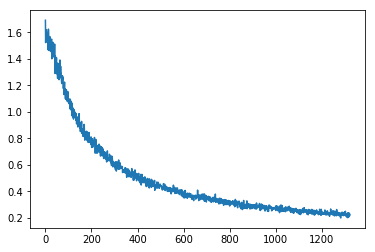

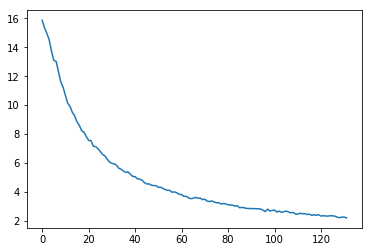

In [20]:
showPlot(plot_losses)
showPlot_avg(plot_losses,10)

In [21]:
#儲存
save_encoder_path = r'D:\Backup\ml_data\GitHub\chat-robot_seq2seq\word2vec_model\model\encoder'
save_decoder_path = r'D:\Backup\ml_data\GitHub\chat-robot_seq2seq\word2vec_model\model\decoder'
torch.save(encoder1.state_dict(), save_encoder_path)
torch.save(attn_decoder1.state_dict(), save_decoder_path)

In [22]:
#評估
#傳入encoder、decoder、你輸入的句子、max_length
def evaluate(sentence,encoder, decoder, max_length):
    userdict_path = './jieba_dict/ptt_userdict.txt'
    jieba_dict = 'jieba_dict/jieba_merge.txt'
    sentence = ML_utils.Jieba_str_segmentation(sentence,
                                           dict_path=jieba_dict,
                                           load_userdict_path=userdict_path,split=True,HMM=False)
    sentence = sentence[:-1]
    seq = ["__SOS.Token__"]
    seq.extend(sentence)
    seq.append("__EOS.Token__")
    over_max_length = 0
    if len(seq) > max_seq_len:
        print("Sentence is too long")
        over_max_length = 1
    if over_max_length == 0:
        input_tensor = strlist_to_vec(word_vectors,seq)
        input_tensor = torch.tensor(input_tensor,dtype=dtype,device=device)
        #禁止計算梯度
        with torch.no_grad():
            #記錄長度
            input_length = input_tensor.size()[0]
            #初始化encoder的h0
            encoder_hidden = initHidden(encoder.rnn_num_layers,encoder.hidden_size,device=device)
            #儲存輸出的encoder
            encoder_outputs = init_encoder_outputs(encoder.max_length, encoder.output_size, device=device)
            #與train相同值行forward
            for ei in range(input_length):
                encoder_output, encoder_hidden = encoder(input_tensor[ei],encoder_hidden)
                encoder_outputs[ei] += encoder_output.reshape(-1)

            decoder_input = input_tensor[0]
            decoder_hidden = initHidden(encoder.rnn_num_layers,decoder.hidden_size, device=device)
            #創建列表儲存預測的字
            decoded_words = []
            #decoder_attentions 學到的權重max_length的權重儲存，這個字學到的權重儲存
            decoder_attentions = torch.zeros(max_length, max_length)
            #不使用teacher_forcing
            for di in range(max_length):
                decoder_output, decoder_hidden, decoder_attention = decoder(
                    decoder_input, decoder_hidden, encoder_outputs)
#                 print(decoder_output.reshape(-1).cpu().numpy())
                predict_word = wordvec2str(word_vectors,decoder_output.reshape(-1).cpu().numpy())
                decoded_words.append(predict_word)
                decoder_attentions[di] = decoder_attention.reshape(-1)
                if predict_word == "__EOS.Token__":
                    break
                else:
                    #將decoder_output作為下個序列的輸入
                    decoder_input = decoder_output
        return decoded_words, decoder_attentions,seq

In [28]:
evaluate("想你醒在午夜零點零三分",encoder1,attn_decoder1,max_seq_len)

Building prefix dict from D:\Backup\ml_data\GitHub\chat-robot_seq2seq\jieba_dict\jieba_merge.txt ...
Loading model from cache C:\Users\Jhin\AppData\Local\Temp\jieba.uce9186881637619ca72120272e27f9ca.cache
Loading model cost 1.224 seconds.
Prefix dict has been built succesfully.


([[('太早', 0.7956090569496155)],
  [('…', 0.8930370807647705)],
  [('的', 0.48291081190109253)],
  [('分析', 0.33271002769470215)],
  [('捏', 0.46583813428878784)],
  [('都', 0.4280359148979187)],
  [('這樣', 0.463359534740448)],
  [('steradian', 0.29263508319854736)],
  [('無聊', 0.4301411509513855)],
  [('須臾', 0.4583451449871063)],
  [('赴', 0.30880627036094666)],
  [('做得好', 0.3122762143611908)],
  [('不行', 0.5007660388946533)],
  [('不來', 0.4884723126888275)],
  [('弔', 0.29437893629074097)],
  [('去', 0.44661813974380493)],
  [('呀', 0.5126723051071167)],
  [('白日', 0.3789873421192169)],
  [('上去', 0.36961010098457336)],
  [('唾', 0.3961651623249054)],
  [('不行', 0.39238569140434265)],
  [('凡事', 0.36355751752853394)]],
 tensor([[3.3687e-04, 1.8354e-09, 2.7904e-06, 7.3788e-02, 8.5875e-01, 1.4095e-06,
          1.1376e-04, 3.2617e-05, 2.0402e-02, 1.4810e-02, 3.6786e-04, 1.4400e-03,
          4.9008e-04, 1.9323e-03, 3.8916e-08, 1.8216e-03, 2.8442e-10, 1.0163e-07,
          1.3387e-02, 2.8946e-04, 5.9448e